In [1]:
from math import sqrt
import os
import glob

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import lstm2
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


# Introduction

This notebook is to read SP500 stocks trained for 30 day predictions and visualize the top results

In [2]:
config_file = '../config/sp500_30.config'
source_dir, nlp_dir, revenue_dir, models_dir, supervised_data_dir, prediction_data_dir, rmse_csv,n_lags, n_forecast, n_test, n_neurons = lstm2.read_config(config_file)

('../data/sp500/orig', '../data/nlp_by_company', '../metadata/revenue', '../models/sp500_30', '../data/sp500_sup_30', '../data/sp500_pred_30', '../data/rsme_sp500_30.csv')
('n_lags, n_forecast, n_test, n_neurons', 5, 30, 90, 10)


In [3]:
def plot_data(rmse_df, predicted_dfs):
    cnt = 1
    for index, row in rmse_df.iterrows():
        key = row['Stock Model']
        if (cnt % 2 != 0):
            fig, axes = plt.subplots(nrows=1, ncols=2)
            ax=axes[0]
        else:
            ax=axes[1]
        predicted_dfs[key].plot(title=key + ': n_forecast = ' + str(n_forecast) +
                                ', n_lags = ' + str(n_lags) + ': price vs days', 
                                figsize=(15,4), 
                                ax=ax)
        cnt += 1
    plt.show()

# Visualize Results

In [4]:
# Look at data from SP500
predicted_dfs, summary_df = lstm2.read_prediction_files('../data/sp500_pred_30')
#top_stocks = summary_df.head(10)
day0_pred_stocks = summary_df.loc[summary_df['Day 0 predicted gain'] > 0.1]
day0_pred_stocks

lstm2.py:344: RuntimeWarning: divide by zero encountered in double_scalars
  predict_gain = (predicted[0] - current[0]) / current[0]
lstm2.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  actual_gain = (actual[0] - current[0]) / current[0]


,Stock Model,rsme,predicted_std,actual_std,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain,sort
452,UA,5.995701,0.780171,1.998956,0.192991,0.138393,0.225918,-0.098756,0.037680
325,M,4.383029,0.896368,1.409051,0.126094,0.021735,0.154878,-0.033394,0.035336
30,AMAT,6.248669,1.649154,4.812977,0.149241,-0.056240,0.179666,0.076254,0.028753
272,KSS,3.058498,1.346005,2.786148,0.103563,0.048727,0.061406,0.052609,0.020077
246,INTU,18.393867,6.630393,6.066981,0.100001,0.037905,0.147009,0.023126,0.007992
55,AYI,28.113746,9.917129,15.658177,0.110264,0.180675,0.085601,-0.019603,0.003045


In [5]:
day0_actual_stocks = summary_df.loc[summary_df['Day 0 actual gain'] > 0.1].sort_values(
    by='Day 0 actual gain', ascending=False)
day0_actual_stocks.head(10)

,Stock Model,rsme,predicted_std,actual_std,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain,sort
66,BHF,57.689876,0.011048,15.298044,-inf,inf,-1.000392,0.569949,-0.017341
231,HRB,3.479317,2.126246,2.320037,0.011690,0.212298,0.022323,-0.029490,0.006416
326,NAVI,1.681728,0.699145,1.323043,0.030992,0.198564,-0.000907,-0.058639,-0.000539
31,AMD,1.653083,0.670166,0.870796,0.048322,0.194746,-0.062338,0.019549,-0.037710
55,AYI,28.113746,9.917129,15.658177,0.110264,0.180675,0.085601,-0.019603,0.003045
261,JWN,4.483224,1.553697,2.579945,0.090523,0.154909,0.043468,-0.018891,0.009696
273,KSU,11.656023,1.759747,1.850708,-0.012799,0.154522,-0.090649,0.021252,-0.007777
87,CELG,21.243730,3.716110,12.545277,-0.040982,0.151154,-0.112984,0.004568,-0.005318
109,COH,4.203898,1.878659,2.975201,0.001345,0.151023,-0.033899,-0.006952,-0.008064
450,UAA,3.900652,1.870791,2.179238,0.062204,0.148340,0.084385,-0.093886,0.021634


In [6]:
top_avg_pred = summary_df.loc[summary_df['Avg predicted gain'] > 0.1].sort_values(
                            by='Avg predicted gain', ascending=False)
top_avg_pred

,Stock Model,rsme,predicted_std,actual_std,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain,sort
190,FL,19.636657,5.596897,7.134847,0.027099,-0.165422,0.252697,-0.156144,0.012869
2,AAP,39.492649,8.991489,8.800171,0.051297,-0.285736,0.231058,-0.124070,0.005851
452,UA,5.995701,0.780171,1.998956,0.192991,0.138393,0.225918,-0.098756,0.037680
30,AMAT,6.248669,1.649154,4.812977,0.149241,-0.056240,0.179666,0.076254,0.028753
44,APC,8.369126,2.166557,3.052629,0.088163,-0.159199,0.167034,0.006995,0.019958
11,ADSK,15.016974,4.678567,5.552236,0.045013,-0.094919,0.164539,0.034226,0.010957
325,M,4.383029,0.896368,1.409051,0.126094,0.021735,0.154878,-0.033394,0.035336
246,INTU,18.393867,6.630393,6.066981,0.100001,0.037905,0.147009,0.023126,0.007992
226,HOLX,9.910394,3.943641,3.059067,-0.020427,0.045855,0.123841,-0.057759,0.012496
188,FLR,6.309706,0.727756,2.827181,0.048856,0.013450,0.121257,-0.012039,0.019217


In [7]:
top_avg_actual = summary_df.loc[summary_df['Avg actual gain'] > 0.1].sort_values(
                            by='Avg actual gain', ascending=False)
top_avg_actual

,Stock Model,rsme,predicted_std,actual_std,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain,sort
66,BHF,57.689876,0.011048,15.298044,-inf,inf,-1.000392,0.569949,-0.017341
338,NRG,6.074168,3.873633,2.257076,-0.128370,0.052632,-0.087343,0.141866,-0.014379
25,ALGN,15.331792,14.540052,23.313481,0.097636,0.100217,0.072823,0.123273,0.004750
269,KORS,6.422588,2.900092,5.524920,-0.006896,-0.012476,-0.011944,0.118274,-0.001860
323,MU,9.950624,2.094188,5.194247,-0.064546,0.087313,-0.128526,0.113224,-0.012916
3,ABBV,15.189487,3.511375,9.452348,-0.024345,0.107580,-0.073478,0.106286,-0.004837
90,CF,3.735544,0.909857,3.420842,0.063826,0.015200,0.025368,0.105889,0.006791
60,BA,16.743094,29.815852,18.721054,0.025113,0.098764,0.071647,0.104381,0.004279
460,URI,24.965130,6.664120,12.888911,-0.103924,0.033183,-0.095127,0.101467,-0.003810


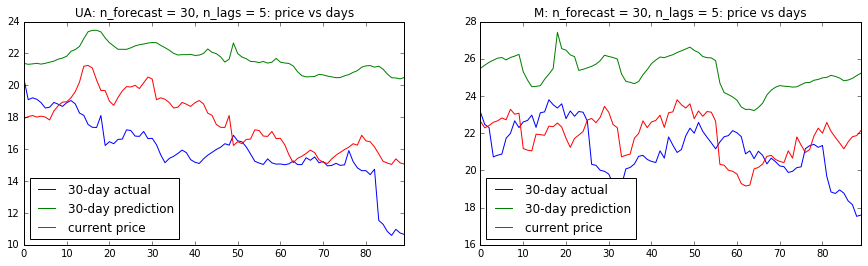

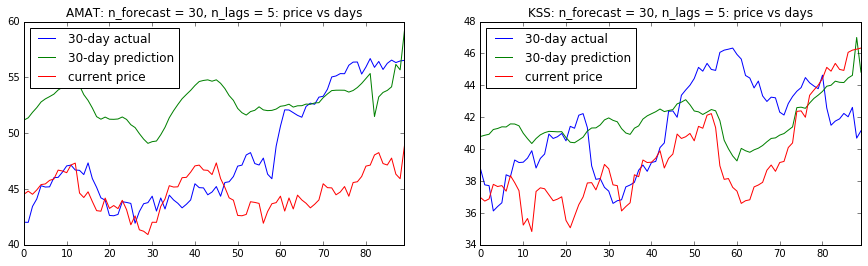

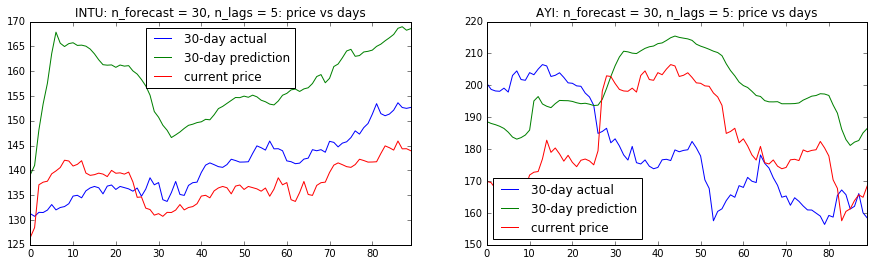

In [8]:
# Plot based on top 1st day prediction prices
plot_data(day0_pred_stocks, predicted_dfs)

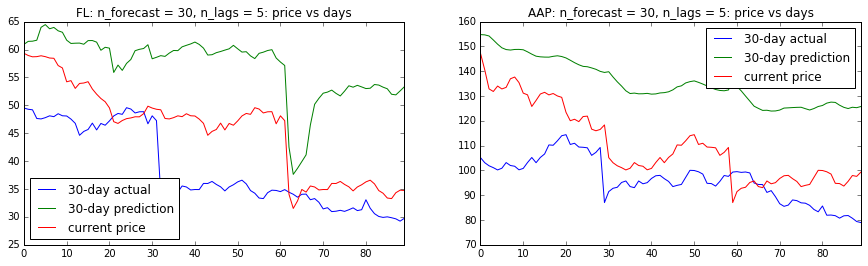

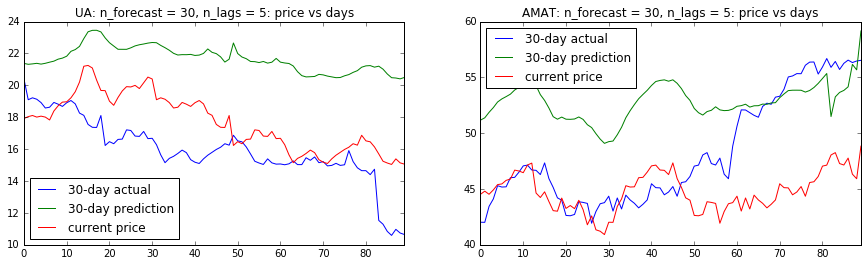

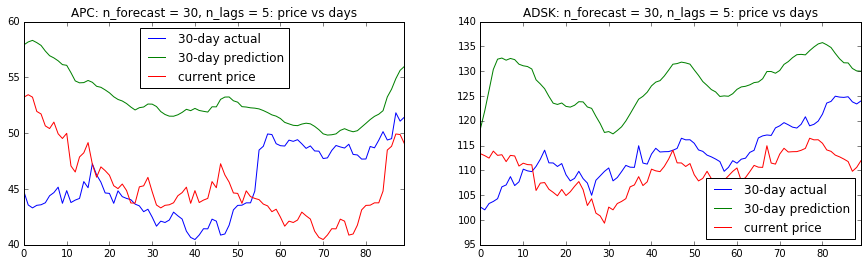

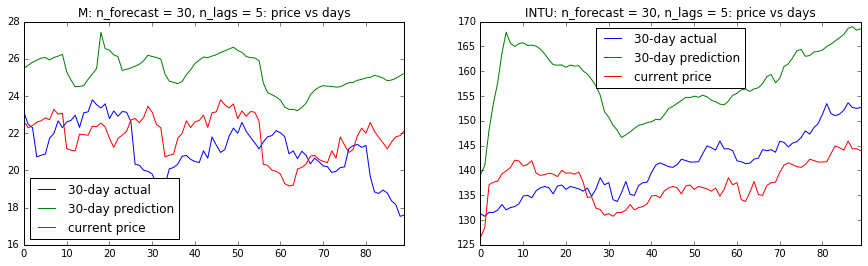

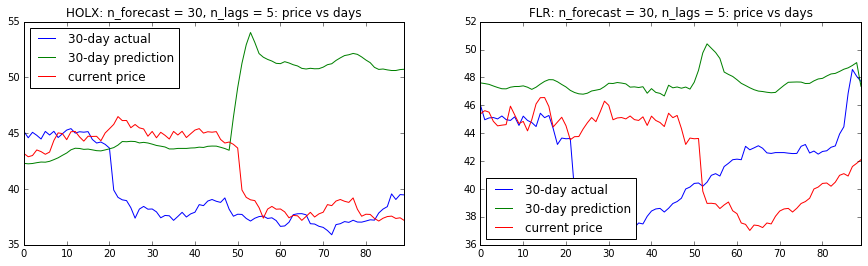

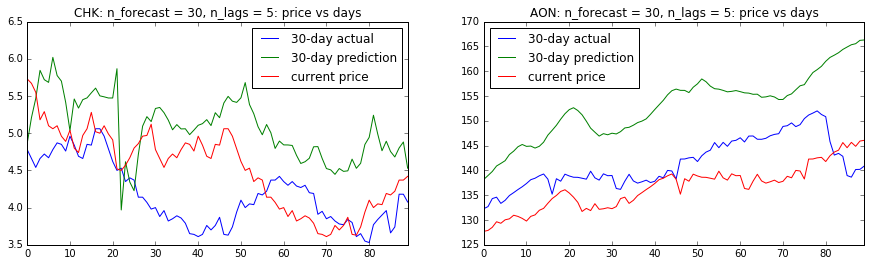

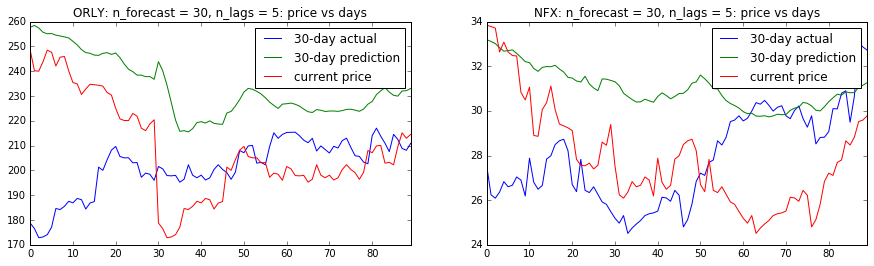

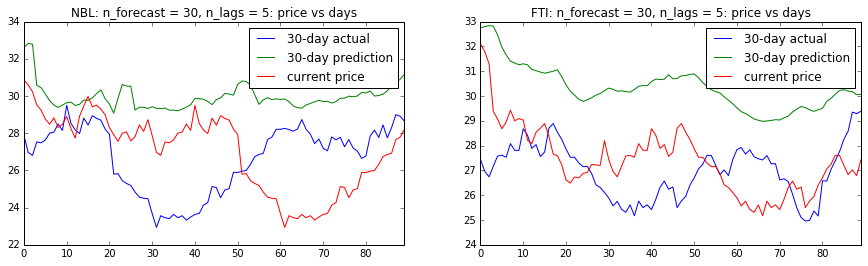

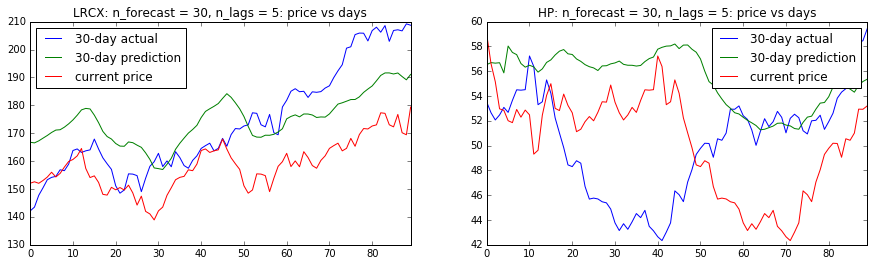

In [9]:
# Plot based on top avg prediction prices
plot_data(top_avg_pred, predicted_dfs)

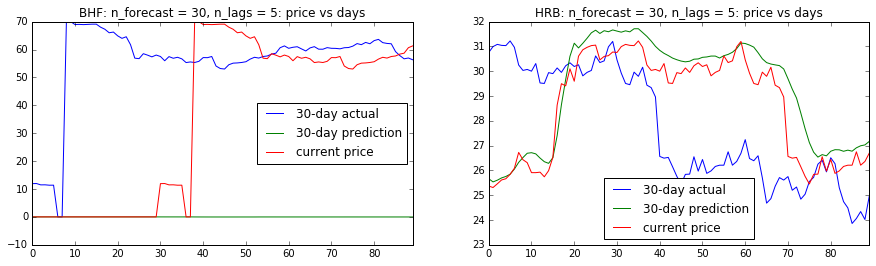

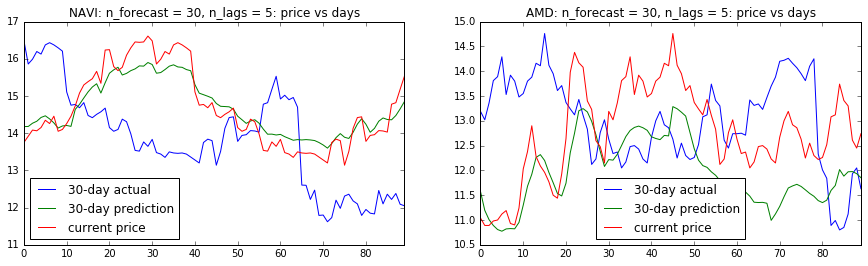

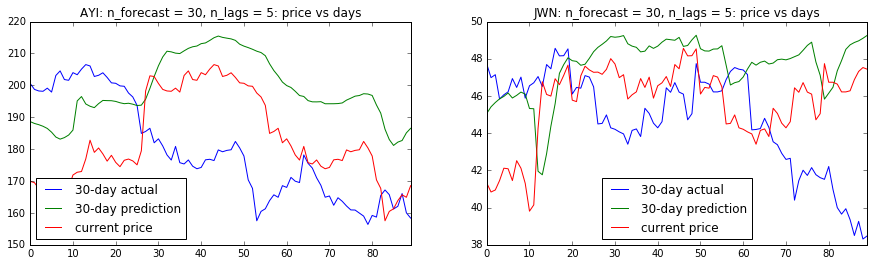

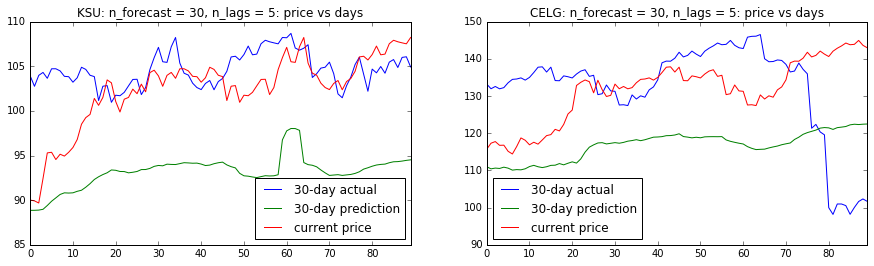

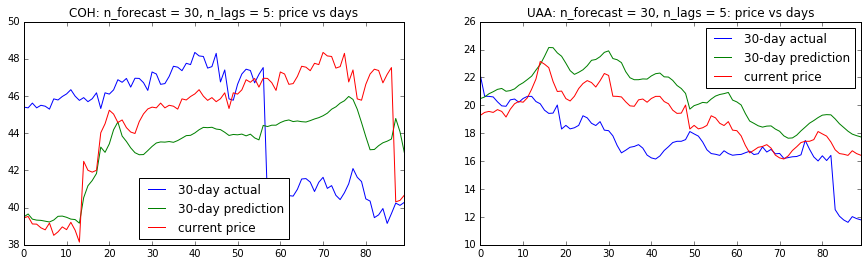

In [10]:
plot_data(day0_actual_stocks.head(10), predicted_dfs)

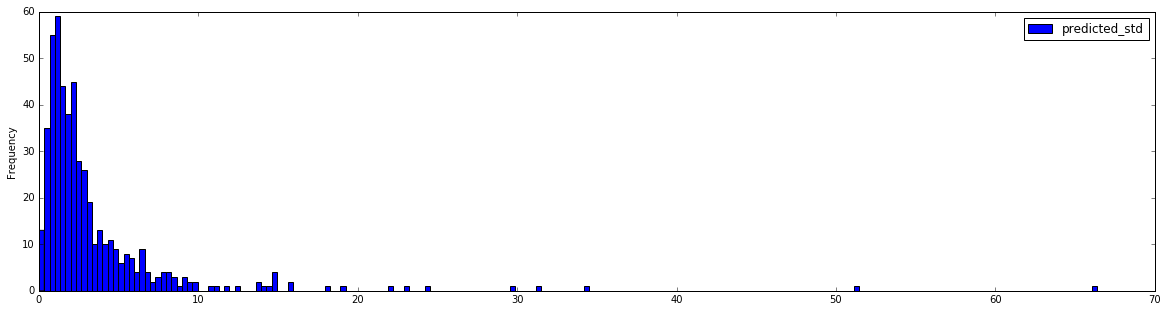

In [48]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
summary_df[['predicted_std']].plot.hist(bins=200, ax=ax)
plt.show()

In [32]:
summary_df[['predicted_std']].describe()

,predicted_std
count,501.000000
mean,3.458601
std,5.331078
min,0.011048
25%,1.122481
50%,2.071632
75%,3.758617
max,66.364681


In [40]:
predicted_dfs_60, summary_df_60 = lstm2.read_prediction_files('../data/sp500_pred_60')
summary_df_60[['predicted_std']].describe()

,predicted_std
count,501.000000
mean,3.593569
std,6.559779
min,0.007022
25%,0.960435
50%,1.857517
75%,3.575332
max,104.491023


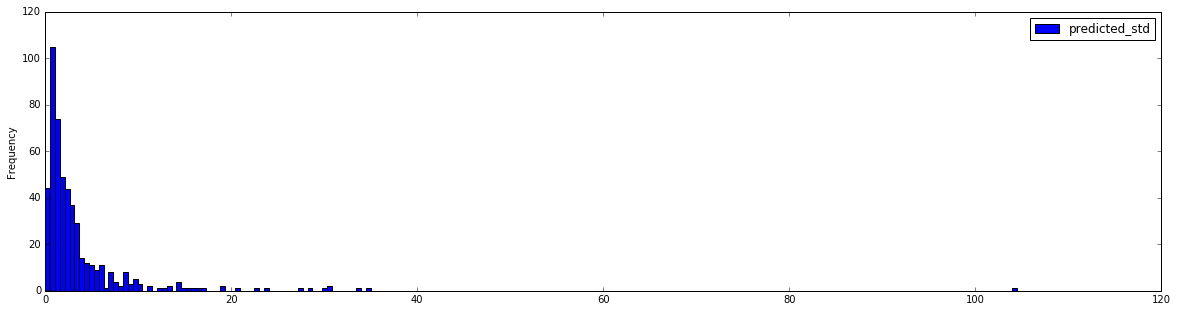

In [46]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
summary_df_60[['predicted_std']].plot.hist(bins=200, ax=ax)
plt.show()

In [44]:
predicted_dfs_45, summary_df_45 = lstm2.read_prediction_files('../data/sp500_pred_45')
summary_df_45[['predicted_std']].describe()

,predicted_std
count,501.000000
mean,3.023243
std,5.366098
min,0.065982
25%,0.891457
50%,1.679958
75%,3.277143
max,76.025165


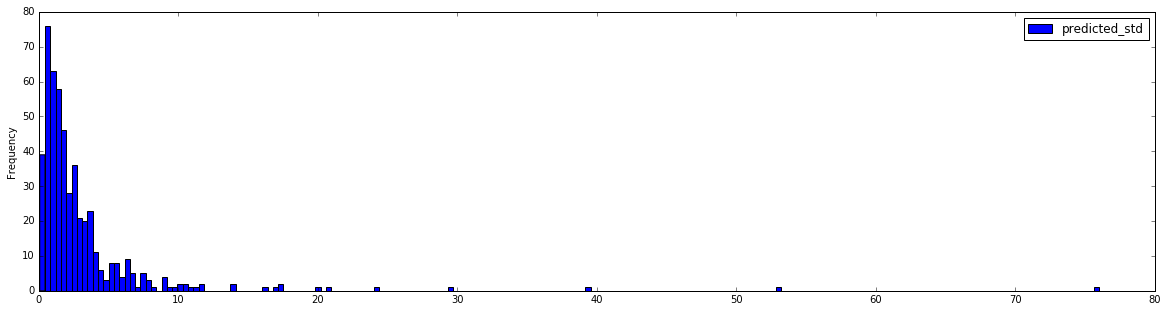

In [47]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
summary_df_45[['predicted_std']].plot.hist(bins=200, ax=ax)
plt.show()